<font size = '6'> YOLOV5 ALPR MODEL INFERENCING 

1. LOADING LIBRARIES

In [3]:
import cv2
import easyocr
import numpy as np
from PIL import Image
from IPython.display import display

2. PREDICTION AND OPTICAL CHARACTER RECOGNITION CODE (OCR)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


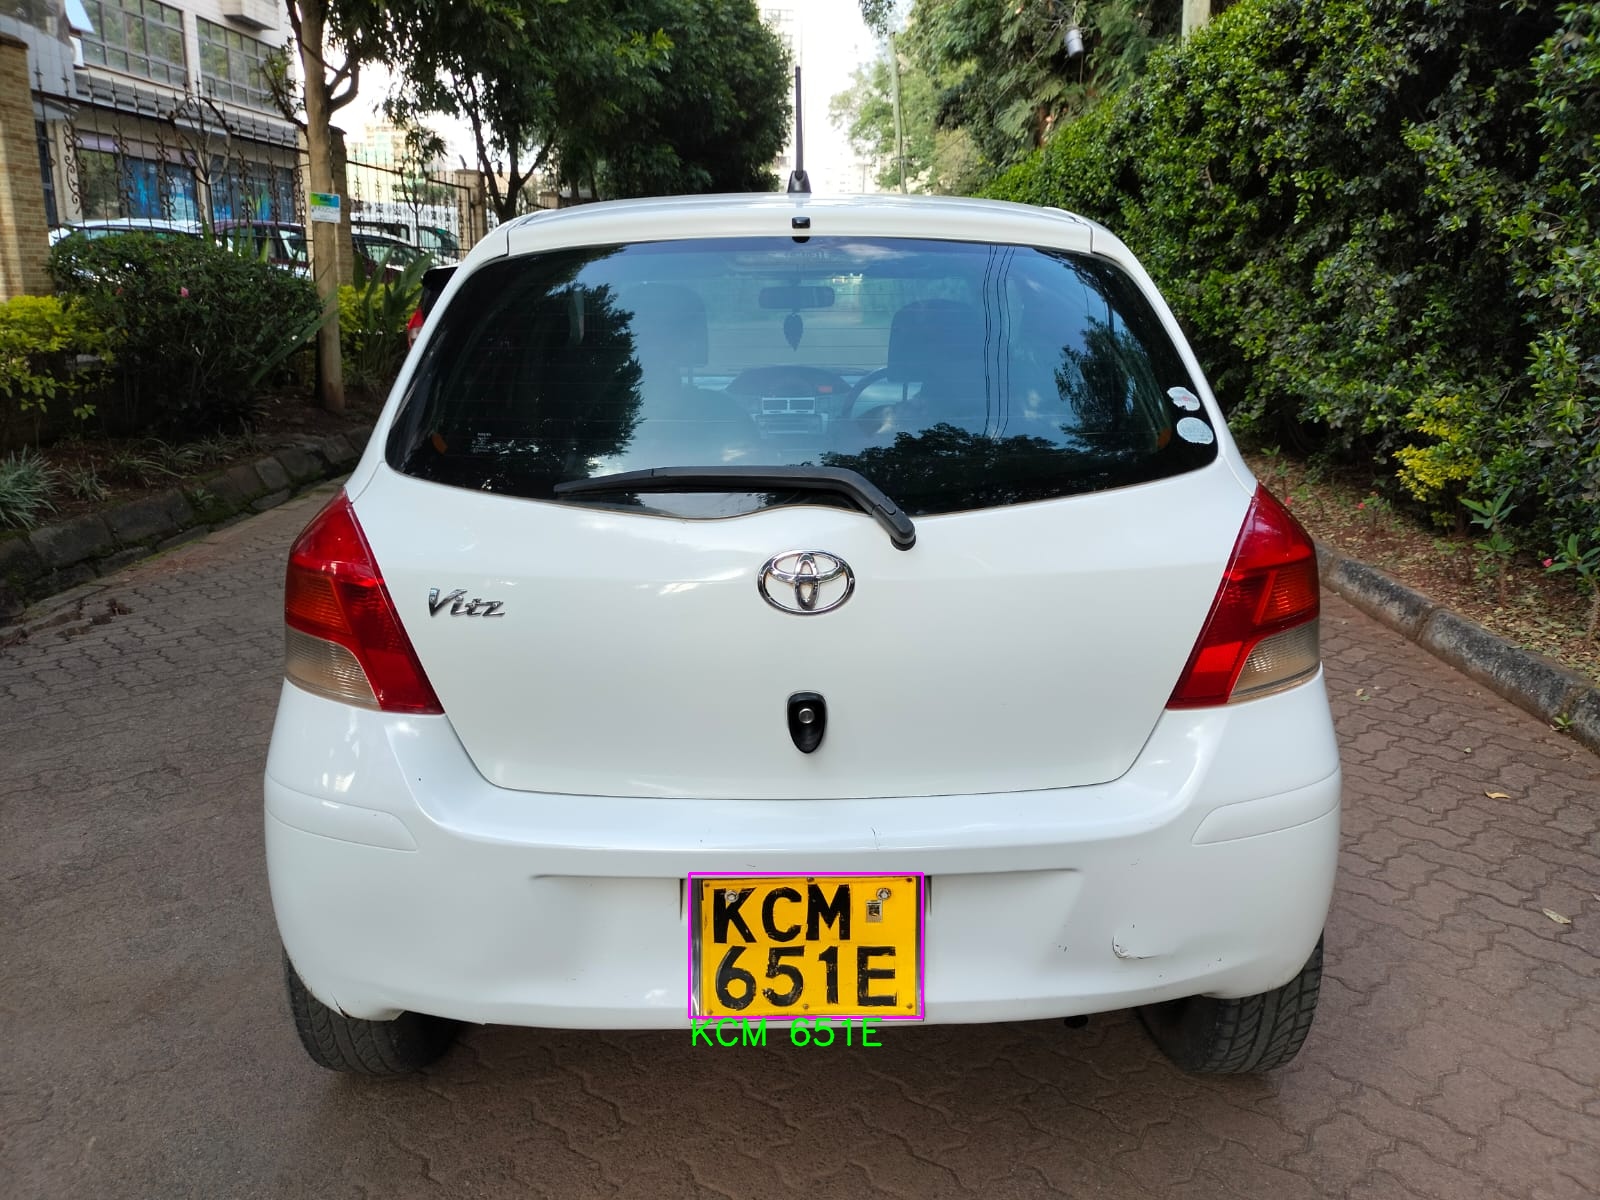

Object Detection Results:
Object 1:
  Class: license_plate
  Confidence: 0.9334750175476074
  Bounding Box: [689, 873, 922, 1017]
  OCR Results:
    OCR 1: ([[16, 2], [174, 2], [174, 78], [16, 78]], 'KCM', 0.9999541623474844)
    OCR 2: ([[18, 60], [221, 60], [221, 144], [18, 144]], '651E', 0.9960817694664001)



In [9]:

# Variables for normalizing model image input
INPUT_WIDTH = 640
INPUT_HEIGHT = 640

# Load YOLOv5 Trained Object Detection model
net = cv2.dnn.readNetFromONNX('yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Function to perform YOLO object detection
def get_detections(img, net):
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row, col)
    input_image = np.zeros((max_rc, max_rc, 3), dtype=np.uint8)
    input_image[0:row, 0:col] = image

    blob = cv2.dnn.blobFromImage(input_image, 1/255, (INPUT_WIDTH, INPUT_HEIGHT), swapRB=True, crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]

    return input_image, detections

def non_maximum_suppression(input_image, detections):
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w / INPUT_WIDTH
    y_factor = image_h / INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4]
        if confidence > 0.4:
            class_score = row[5]
            if class_score > 0.25:
                cx, cy, w, h = row[0:4]

                left = int((cx - 0.5 * w) * x_factor)
                top = int((cy - 0.5 * h) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)
                box = np.array([left, top, width, height])

                confidences.append(confidence)
                boxes.append(box)

    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    index = cv2.dnn.NMSBoxes(boxes_np, confidences_np, 0.25, 0.45)

    return boxes_np, confidences_np, index

def perform_ocr_on_rois(image, boxes_np, confidences_np, index):
    reader = easyocr.Reader(['en'])
    results_list = []

    for ind in index:
        x, y, w, h = boxes_np[ind]
        bb_conf = confidences_np[ind]

        roi = image[y:y+h, x:x+w]

        if 0 not in roi.shape:
            results = reader.readtext(roi)
            results_list.append(results)

    return results_list

def yolo_predictions(img, net):
    input_image, detections = get_detections(img, net)
    boxes_np, confidences_np, index = non_maximum_suppression(input_image, detections)
    results_list = perform_ocr_on_rois(img, boxes_np, confidences_np, index)
    result_img = img.copy()
    object_results = []

    for i, ind in enumerate(index):
        x, y, w, h = boxes_np[ind]
        bb_conf = confidences_np[ind]
        results = results_list[i]

        object_info = {
            'class': 'license_plate',  
            'confidence': float(bb_conf),
            'box': [int(x), int(y), int(x+w), int(y+h)],
            'ocr_results': results
        }
        object_results.append(object_info)

        cv2.rectangle(result_img, (x, y), (x+w, y+h), (255, 0, 255), 2)

        # Print OCR results on the image
        combined_text = ' '.join(detection[1] for detection in results)
        text_position = (x, y + h + 27)
        text_font = cv2.FONT_HERSHEY_SIMPLEX
        text_scale = 1.2
        text_thickness = 2
        text_color = (0, 255, 0)
        cv2.putText(result_img, combined_text.strip(), text_position, text_font, text_scale, text_color, text_thickness, cv2.LINE_AA)

    return result_img, object_results

# Test 'yolo_predictions' function, You can edit this path and use any other image in the images folder.
img = cv2.imread('images/kenyan24.jpg')
results_image, object_results = yolo_predictions(img, net)

# Convert the OpenCV image to PIL format for display
results_pil = Image.fromarray(cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
display(results_pil)

# Print object detection and OCR results
print("Object Detection Results:")
for i, obj_result in enumerate(object_results):
    print(f"Object {i+1}:")
    print(f"  Class: {obj_result['class']}")
    print(f"  Confidence: {obj_result['confidence']}")
    print(f"  Bounding Box: {obj_result['box']}")
    print("  OCR Results:")
    for j, ocr_result in enumerate(obj_result['ocr_results']):
        print(f"    OCR {j+1}: {ocr_result}")

    print() 